In [73]:
import os
import re
import pandas as pd
import PyPDF2 
import textract
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [63]:
os.chdir("/Users/ajeet/Google Drive/Internship")

In [64]:
ls

Automatic email content store.csv  amount.jpg
EpoAutomationContent.jpeg          image.jpg
EpoAutomationContentPNG.png        output.txt.txt
JavaBasics-notes.pdf


# Step 1: Read PDF File

In [65]:
filename = 'JavaBasics-notes.pdf' 

In [66]:
#open allows you to read the file
pdfFileObj = open(filename,'rb')

In [67]:
#The pdfReader variable is a readable object that will be parsed
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)

In [68]:
#discerning the number of pages will allow us to parse through all #the pages
num_pages = pdfReader.numPages
count = 0
text = ""

In [69]:
#The while loop will read each page
while count < num_pages:
    pageObj = pdfReader.getPage(count)
    count +=1
    text += pageObj.extractText()

In [70]:
#This if statement exists to check if the above library returned #words. It's done because PyPDF2 cannot read scanned files.
if text != "":
   text = text
#If the above returns as False, we run the OCR library textract to #convert scanned/image based PDF files into text
else:
   text = textract.process(fileurl, method='tesseract', language='eng')

In [156]:
#print(text)

# Step 2: Analysis of the text

##### Clean the text for analysis only

In [96]:
withoutAnySpecialChar = re.sub("[^a-zA-Z+.]", ' ', text)
withoutAnySpecialChar = withoutAnySpecialChar.lower()
tokens = word_tokenize(withoutAnySpecialChar)

In [97]:
stop_words = stopwords.words('english')
import string

In [98]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [99]:
#We create a list comprehension which only returns a list of words #that are NOT IN stop_words and NOT IN punctuations.
keywords = [ps.stem(word) for word in tokens if not word in stop_words and  not word in string.punctuation]

In [100]:
type(keywords)

list

##### Make dataframe of the tokens to analyse the frequecy distribution

In [102]:
data = pd.DataFrame(keywords)
data = data.rename(columns={0:"Keyword"})

In [103]:
Df = pd.DataFrame(data['Keyword'].value_counts())

In [104]:
Df.head()

,Keyword
java,78
new,48
data,44
applet,40
int,39


In [105]:
Df = Df.reset_index()

In [106]:
Df = Df.rename(columns={'index':'Keyword','Keyword':'Frequency'})

In [107]:
Df.head()

,Keyword,Frequency
0,java,78
1,new,48
2,data,44
3,applet,40
4,int,39


In [108]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

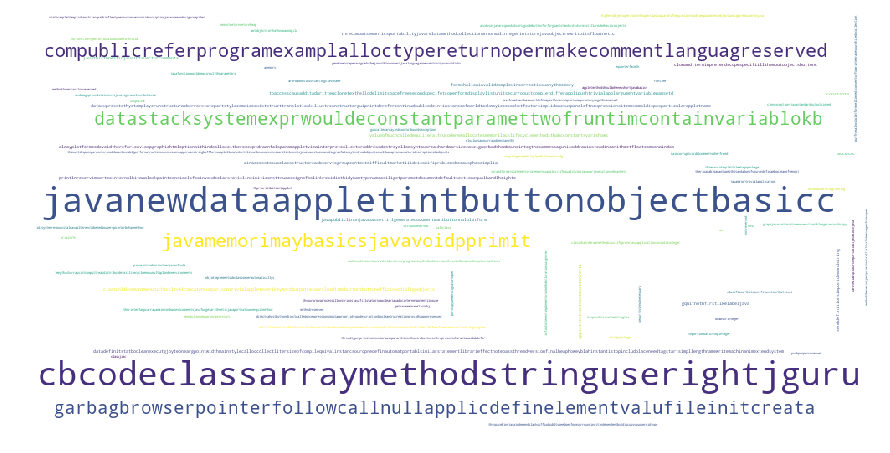

In [109]:
#Plot wordcloud 
wordcloud = WordCloud(width = 1000, height = 500, stopwords = STOPWORDS, background_color = 'white').generate(
                        ''.join(Df['Keyword']))

plt.figure(figsize = (15,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Since it is very un-clear so need to plot some other plot to identify the frequency distribution

In [115]:
#Plot top 20 
data = Df.head(20)

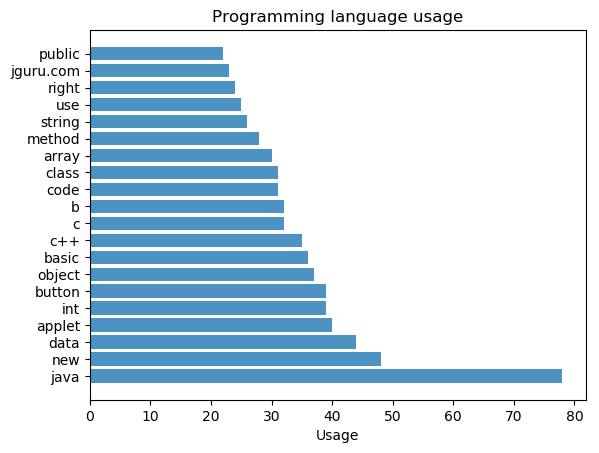

In [118]:
import matplotlib.pyplot as plt; 
plt.rcdefaults()
import numpy as np
objects = data['Keyword']
y_pos = np.arange(len(objects))
performance = data['Frequency']
 
plt.barh(y_pos, performance, align='center', alpha=0.8)
plt.yticks(y_pos, objects)
plt.xlabel('Usage')
plt.title('Programming language usage')
 
plt.show()

There are some irrelavant words present in this text, so we need to remove them manaully else they will affect the final results

In [119]:
stopwords_manual = ['jguru.com','b']

# Calculating the weightages of each keywords 

In [120]:
text = text.replace('...','')

In [121]:
from bs4 import BeautifulSoup 
import string
import re
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [125]:
# 1. Remove HTML
text = BeautifulSoup(text,"lxml").get_text() 

In [129]:
#Break the text into sentenses
sentenses = sent_tokenize(text)

In [130]:
#Clean the each sentence
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [131]:
corpus = []
for i in range(0, len(sentenses)-1):
    review = re.sub('[^a-zA-Z++]', ' ', sentenses[i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [word for word in review if not word in set(stopwords_manual)]
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english')) and  not word in string.punctuation]
    review = ' '.join(review)
    corpus.append(review)

##### Calculate the weights

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [134]:
# Fit the TfidfVectorizer to the training data
vect = TfidfVectorizer().fit(corpus)

In [135]:
# transform the texts in the training data to a document-term matrix
sentenses_vectorized = vect.transform(sentenses)

In [136]:
# find the tfidf value and order the tf_idf_index by importance  
values =  sentenses_vectorized.max(0).toarray()[0]
index = vect.get_feature_names()

In [137]:
# convert the list to the Series required
features_series = pd.Series(values,index = index)

In [155]:
print(features_series.nlargest(21))

alljava       1.000000
applet        1.000000
array         1.000000
bad           1.000000
data          1.000000
destroy       1.000000
either        1.000000
init          1.000000
instanceof    1.000000
java          1.000000
level         1.000000
new           1.000000
object        1.000000
paint         1.000000
point         1.000000
pointer       1.000000
sstill        1.000000
start         1.000000
stop          1.000000
yet           1.000000
left          0.938696
dtype: float64


In [139]:
len(features_series)

706

# Save into file

In [141]:
finalData = pd.DataFrame(features_series.nlargest(708))

In [142]:
finalData.head()

,0
java,1.0
either,1.0
level,1.0
object,1.0
sstill,1.0


In [144]:
finalData = finalData.reset_index()

In [145]:
finalData.head()

,index,0
0,java,1.0
1,either,1.0
2,level,1.0
3,object,1.0
4,sstill,1.0


In [146]:
finalData = finalData.rename(columns={'index':'Keyword',0:'weightages'})

In [152]:
finalData.to_csv("KeywordWeightage.csv", index=False)